<a href="https://colab.research.google.com/github/NarkisRaam/AdvancedMLDL.exercise1/blob/main/exercise3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Assignment III - NLP: Seinfeld or Friends?** 
###**Group members:**

##### Yuval Berland
##### Narkis Raam 
##### Sagi Huly 
##### Dana Shidlovsky

## **Imports**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

from bs4 import BeautifulSoup
import re

import nltk
nltk.download('stopwords')

from tqdm.notebook import tqdm

from nltk.tokenize.toktok import ToktokTokenizer

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dropout, Conv1D, Flatten, Dense, Embedding
from keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer  

from keras.utils import pad_sequences

from sklearn.preprocessing import LabelBinarizer

from sklearn.metrics import accuracy_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## **Load The Data**


In [2]:
train_df = pd.read_csv('https://github.com/odedovadia/AdvancedMLDLCourse/blob/main/Assignments/Assignment%20III/train.csv?raw=true')
test_df = pd.read_csv('https://github.com/odedovadia/AdvancedMLDLCourse/blob/main/Assignments/Assignment%20III/test.csv?raw=true')

## **Visualizations**

In [3]:
print(len(train_df) , len(test_df))
train_df[:10]

70405 4245


,Dialogue,Character,Episode,Show,Dialogue_length
0,Hey.,joey,Season-07 Episode-13-The One Where Rosita Dies,Friends,1
1,(to Joey) Are you gonna be embarrassed going ...,phoebe,Season-10 Episode-04-The One With The Cake,Friends,13
2,"Me? No no no, you. You're gonna tell him. I'm ...",elaine,S03E22,Seinfeld,14
3,Alright you guys are off to party number one ...,chandler,Season-02 Episode-22-The One With the Two Parties,Friends,56
4,Am I? Or am I so sane that you just blew your ...,kramer,S05E12,Seinfeld,13
5,"So, if you’re parents hadn’t got divorced, yo...",monica,Season-03 Episode-17-The One Without The Ski Trip,Friends,18
6,What's up?,ross,Season-05 Episode-18-The One Where Rachel Smokes,Friends,2
7,"(over-enthusiastic) I don't know, I don' I do...",chandler,Season-09 Episode-15-The One With The Mugging,Friends,27
8,I know. *He* always wanted to be the first bl...,chandler,Season-10 Episode-15-The One Where Estelle Dies,Friends,15
9,"This uniform, what's it made from?",george,S06E01,Seinfeld,6


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70405 entries, 0 to 70404
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Dialogue         70405 non-null  object
 1   Character        70405 non-null  object
 2   Episode          70405 non-null  object
 3   Show             70405 non-null  object
 4   Dialogue_length  70405 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.7+ MB


##### Words Count Distribution

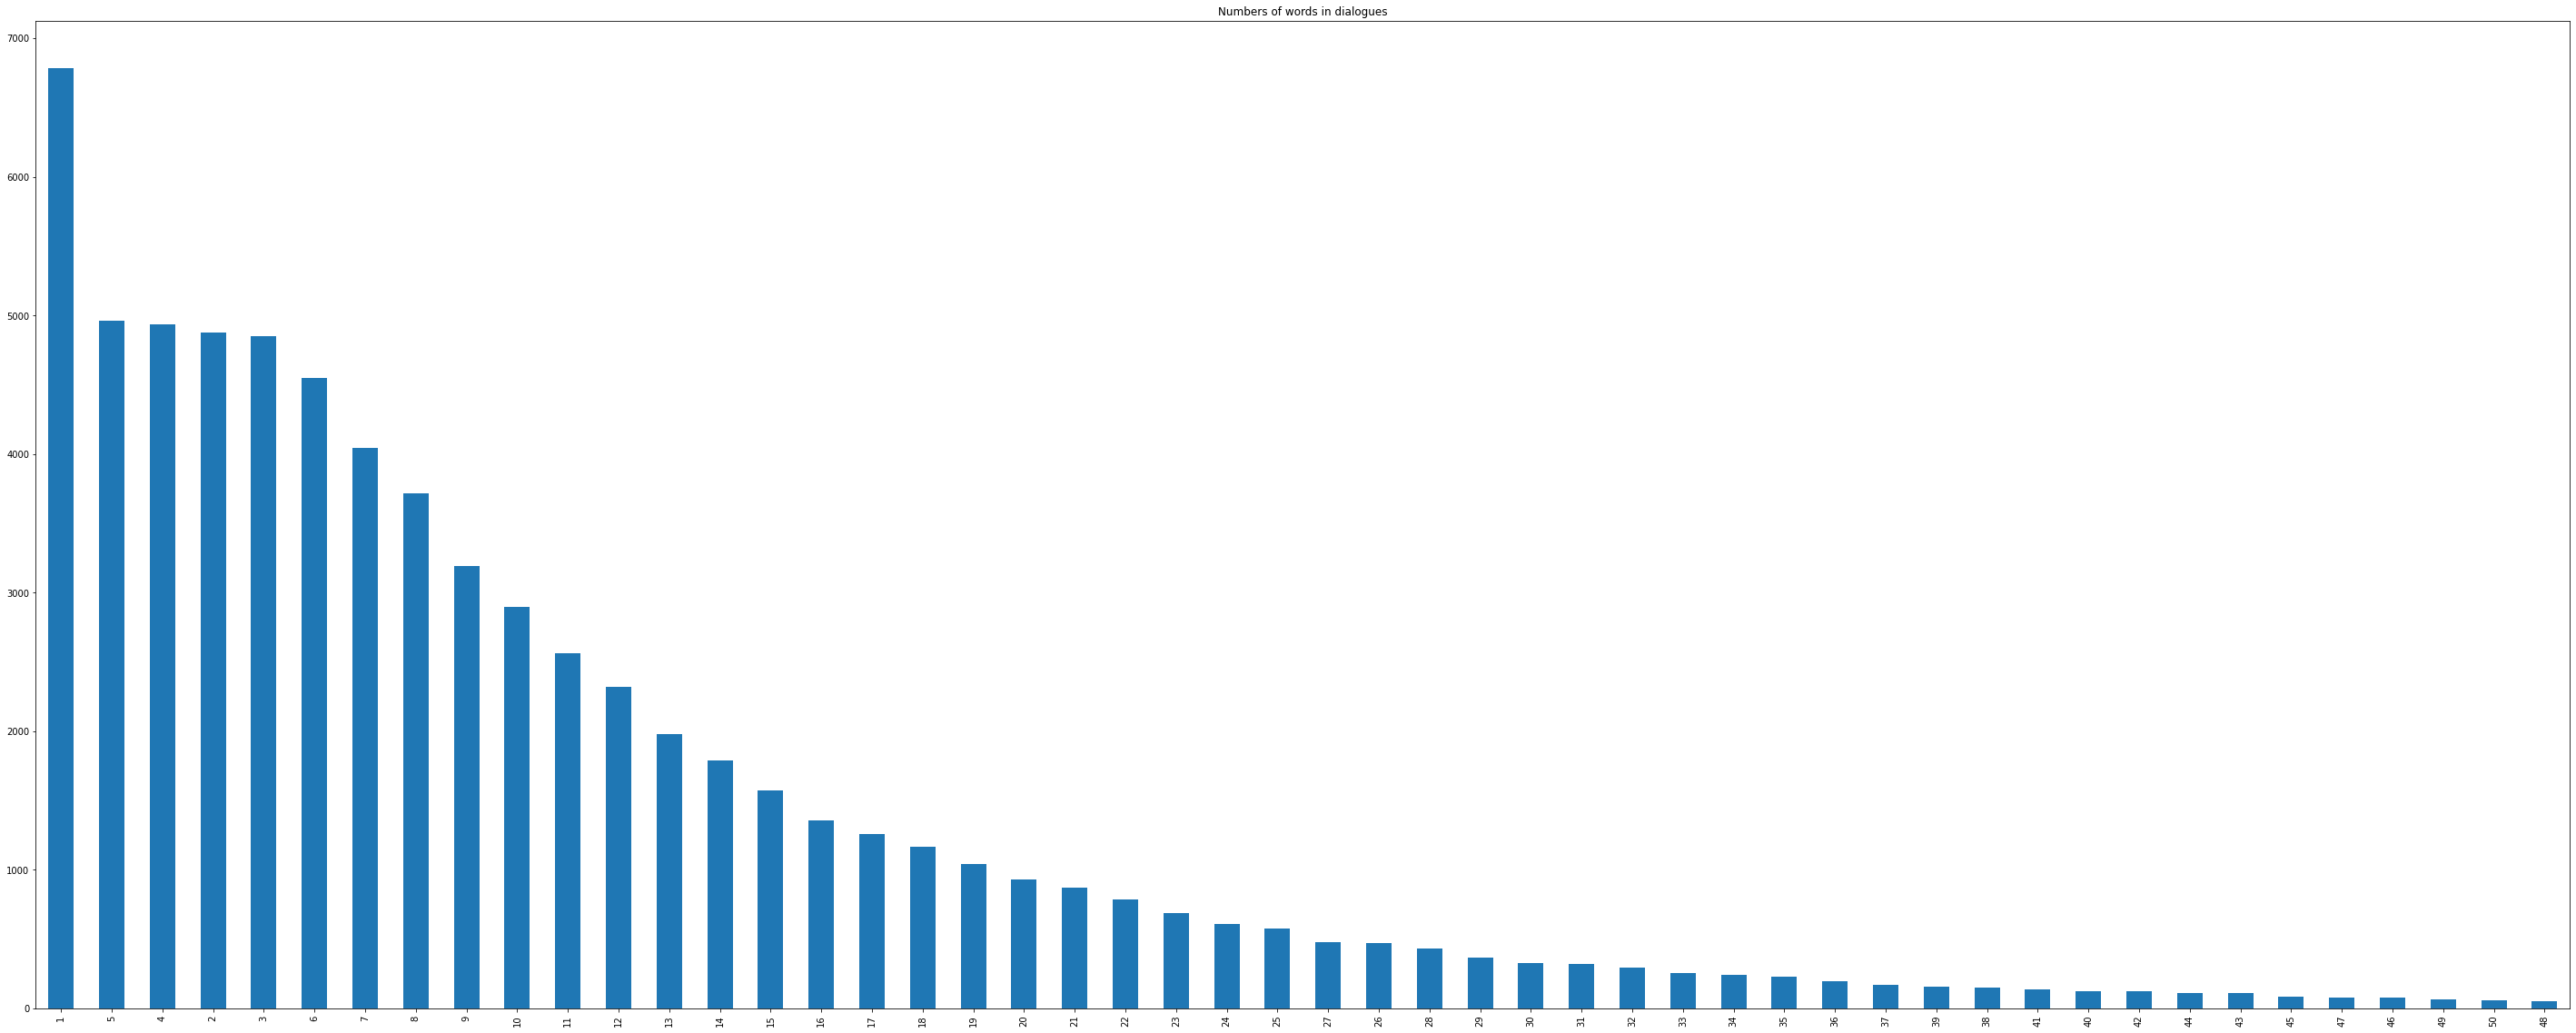

In [5]:
train_df['Dialogue_length'].value_counts()[:50].plot(title='Numbers of words in dialogues', kind='bar', figsize=(50, 20))

##### Labels Distribution

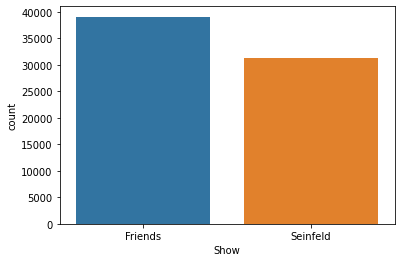

In [6]:
sns.countplot(x=train_df["Show"])

##### Character distribution between shows


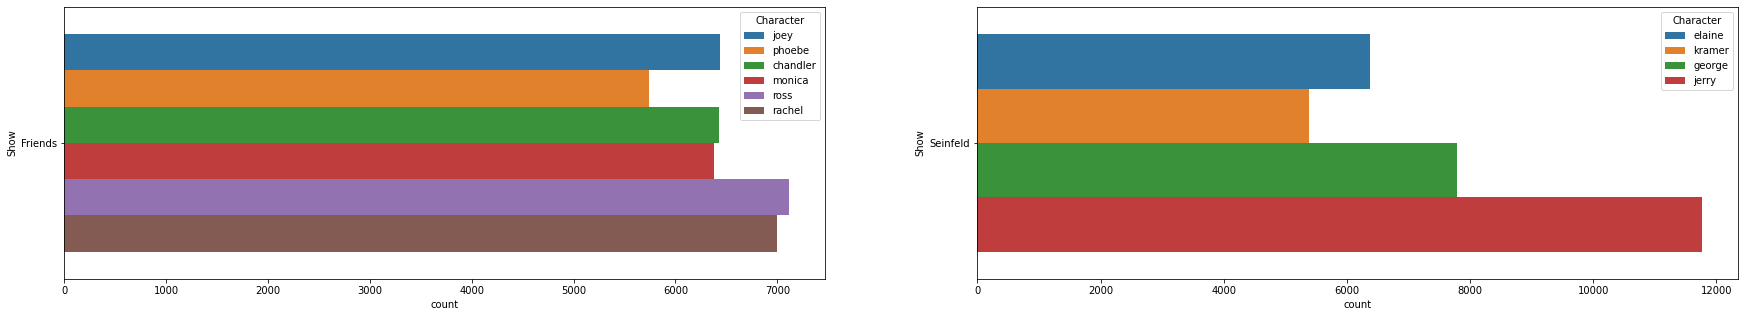

In [7]:
friends_characters = train_df[train_df["Show"] == 'Friends']
seinfeld_characters = train_df[train_df["Show"] == 'Seinfeld']

fig, axs = plt.subplots(1,2)
fig.set_size_inches(30,5)
sns.countplot(data=friends_characters, y="Show", hue="Character", ax=axs[0])
sns.countplot(data=seinfeld_characters, y="Show", hue="Character", ax=axs[1])

##### Words Count Distribution In Friends


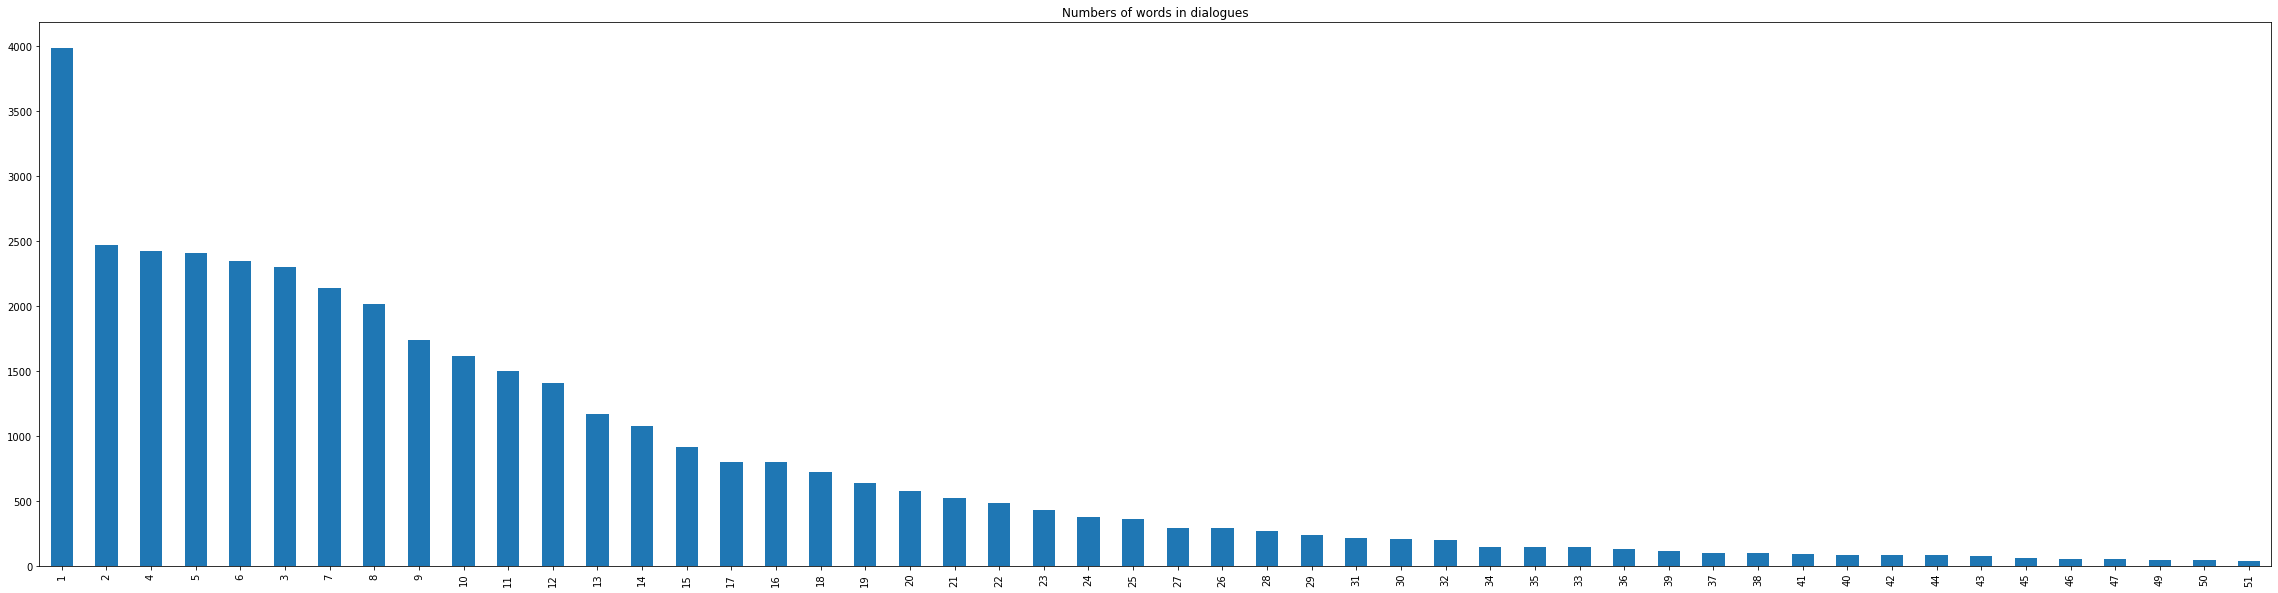

In [8]:
friends_characters['Dialogue_length'].value_counts()[:50].plot(title='Numbers of words in dialogues', kind='bar', figsize=(40, 10))

##### Words Count Distribution In Seinfeld


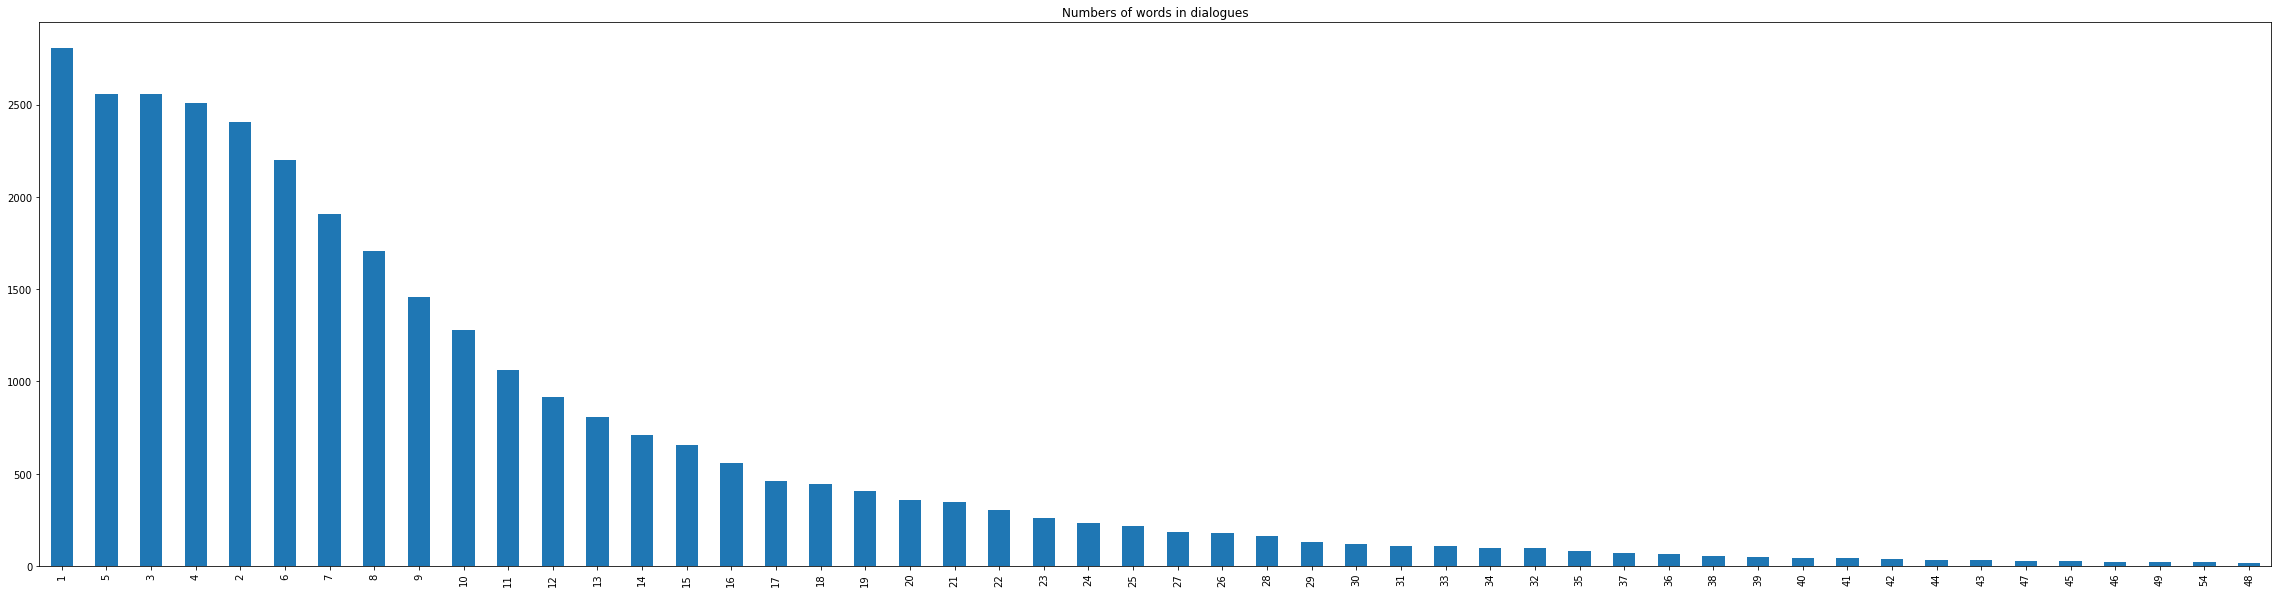

In [9]:
seinfeld_characters['Dialogue_length'].value_counts()[:50].plot(title='Numbers of words in dialogues', kind='bar', figsize=(40, 10))

##### Means dialogue length by character


In [10]:
seinfeld_character_means = pd.DataFrame(seinfeld_characters.groupby(['Character'],sort=True)['Dialogue_length'].mean())
seinfeld_character_means.rename(columns = {'Dialogue_length':'Dialogue_mean'}, inplace = True)
seinfeld_character_means.reset_index(inplace=True)
friends_character_means = pd.DataFrame(friends_characters.groupby(['Character'],sort=True)['Dialogue_length'].mean())
friends_character_means.rename(columns = {'Dialogue_length':'Dialogue_mean'}, inplace = True)
friends_character_means.reset_index(inplace=True)

[Text(0.5, 1.0, 'Friends')]

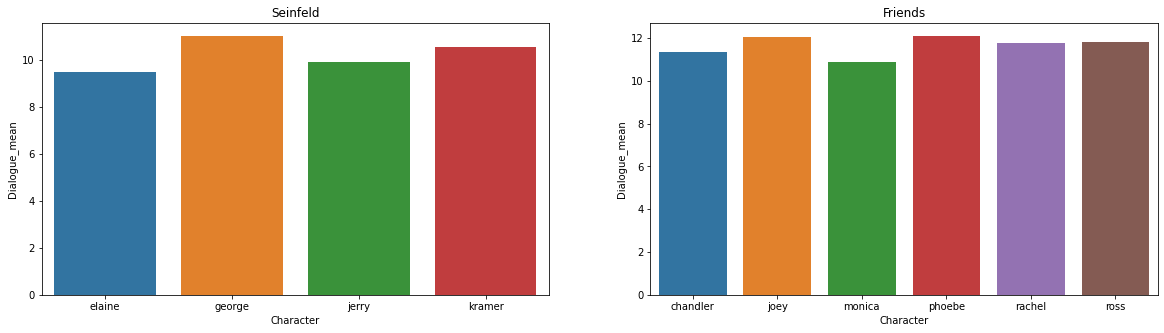

In [11]:
fig, axs = plt.subplots(1,2)
fig.set_size_inches(20,5)
sns.barplot(data=seinfeld_character_means, x="Character",y="Dialogue_mean",ax=axs[0]).set(title='Seinfeld')
sns.barplot(data=friends_character_means, x="Character",y="Dialogue_mean",ax=axs[1]).set(title='Friends')

[Text(0.5, 1.0, 'Seinfeld')]

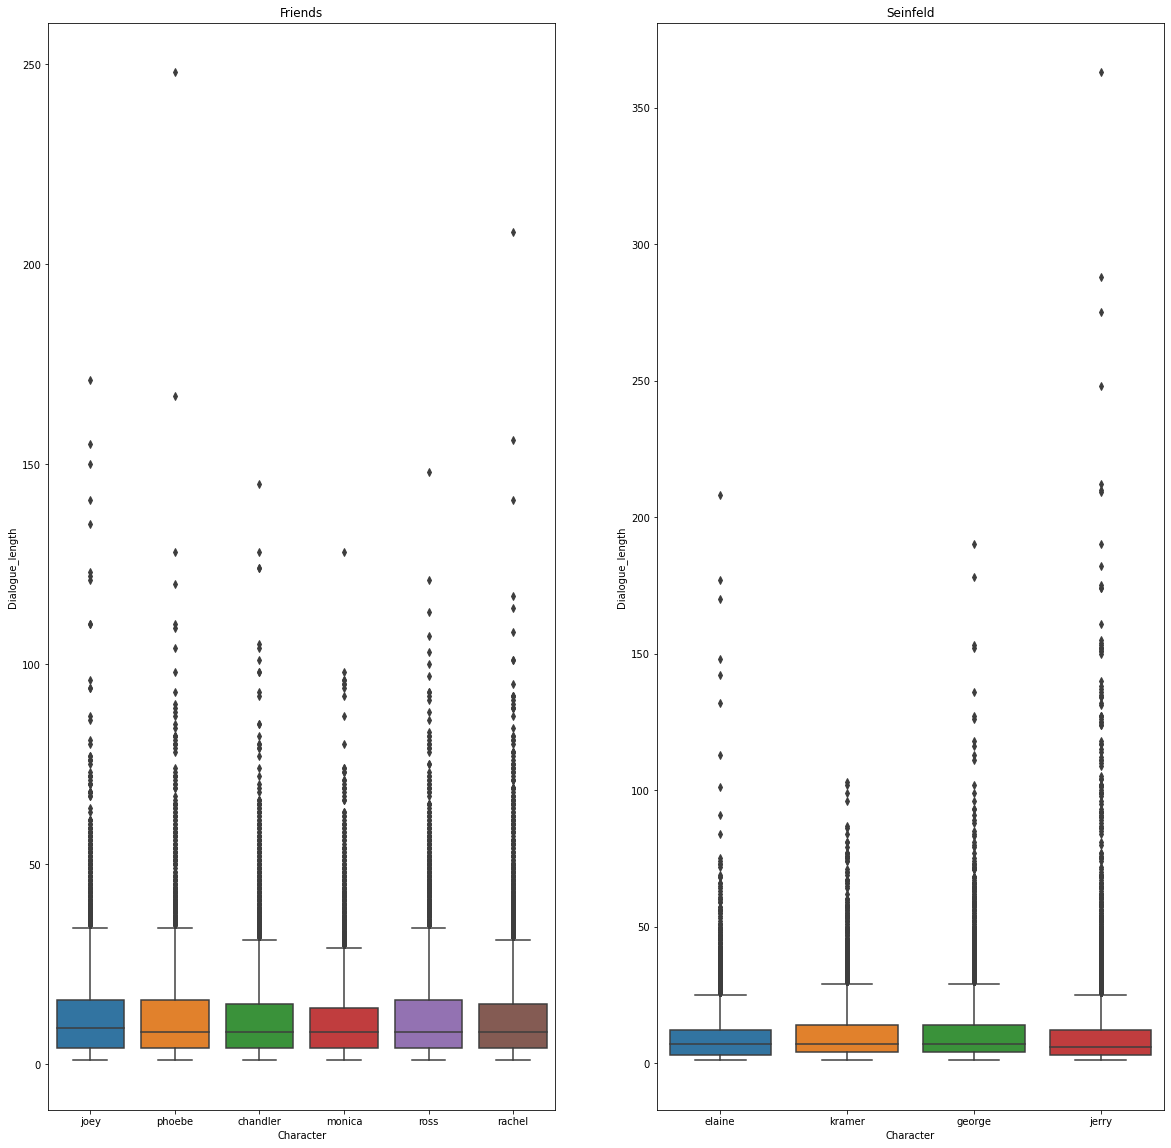

In [12]:
fig, axs = plt.subplots(1,2)
fig.set_size_inches(20,20)
sns.boxplot(data=friends_characters, x="Character", y="Dialogue_length", dodge=False, ax=axs[0]).set(title='Friends')
sns.boxplot(data=seinfeld_characters, x="Character", y="Dialogue_length", dodge=False, ax=axs[1]).set(title='Seinfeld')

##### Prepare data set for pre proccessing


In [13]:
x_train = train_df['Dialogue']
y_train = train_df['Show']

x_test = test_df['Dialogue']
y_test = test_df['Show']
print(x_train[213][:1000])

 (on phone) Hello? (Listens) Hold on please. Joey, it’s your mom. (Hands him the phone.)


## **Pre-processing**

In [14]:
# Droping outliers by Percentiles only for train set 
characters = list(train_df['Character'].unique())
for c in characters:
  threshold = np.percentile(train_df[train_df['Character'] == c]['Dialogue_length'], 99.9)
  train_df.drop(train_df[(train_df['Character'] == c) & (train_df['Dialogue_length'] > threshold)].index, inplace=True) 

In [15]:
print("Number of sampels after cutting outliers dialogue: " + str(train_df.shape[0]))

Number of sampels after cutting outliers dialogue: 70332


In [16]:
x_train = x_train.replace('\n' , ' ')
x_test = x_test.replace('\n' , ' ')

### Remove special characters

In [17]:
# Define function for removing special characters
def remove_special_characters(text):
    pattern = r'[^a-zA-Z0-9\s]'
    text = re.sub(pattern,'',text)
    return text

# Apply function on review column
x_train = x_train.apply(remove_special_characters)
x_test = x_test.apply(remove_special_characters)

### Removing stop words 

In [18]:
stopword_list = nltk.corpus.stopwords.words('english')

tokenizer = ToktokTokenizer()

tokenizer.tokenize(x_train.iloc[1])

['to',
 'Joey',
 'Are',
 'you',
 'gonna',
 'be',
 'embarrassed',
 'going',
 'up',
 'there',
 'having',
 'nothing',
 'prepared']

In [19]:
# Removing the stopwords
tqdm.pandas()

def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

# Apply function on review column
x_train = x_train.progress_apply(remove_stopwords)

  0%|          | 0/70405 [00:00<?, ?it/s]

### Train test split 

In [20]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

train_label_count = y_train.value_counts()
test_label_count = y_test.value_counts()

print(train_label_count)
print(test_label_count)

Friends     31293
Seinfeld    25031
Name: Show, dtype: int64
Friends     2596
Seinfeld    1649
Name: Show, dtype: int64


In [21]:
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)
print('x_val shape:', x_val.shape)
print('y_val shape:', y_val.shape)

x_train shape: (56324,)
y_train shape: (56324,)
x_test shape: (4245,)
y_test shape: (4245,)
x_val shape: (14081,)
y_val shape: (14081,)


### Tokenizing and creating a fixed length for input

In [22]:
token = Tokenizer(lower=False)
token.fit_on_texts(x_train)

x_train = token.texts_to_sequences(x_train)
x_val = token.texts_to_sequences(x_val)
x_test = token.texts_to_sequences(x_test)

In [23]:
doc_len_list = [len(doc) for doc in x_train]

In [24]:
max(doc_len_list), min(doc_len_list), np.mean(doc_len_list)

(185, 0, 5.830427526454087)

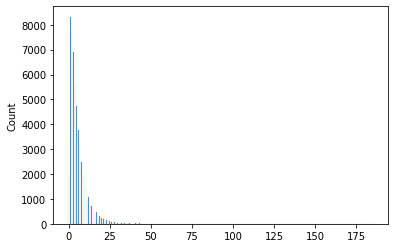

In [25]:
sns.histplot(doc_len_list)

In [26]:
max_words = 30

x_train_dl = pad_sequences(x_train, maxlen=max_words)
x_val_dl = pad_sequences(x_val, maxlen=max_words)
x_test_dl = pad_sequences(x_test, maxlen=max_words)

In [27]:
x_train_dl[10, :]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,  396,  881,  456,  129, 2270,
          3, 8509, 6680,  204,    3,   51,   18,  456], dtype=int32)

In [28]:
total_words = len(token.word_index) + 1 
total_words

25082

In [29]:
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)
y_val = lb.transform(y_val)

## **Creating the Model**

In [30]:
model = Sequential()
model.add(Embedding(input_dim=total_words, output_dim=200, input_length=max_words))
model.add(Conv1D(8, 3, padding='same', activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 200)           5016400   
                                                                 
 conv1d (Conv1D)             (None, 30, 8)             4808      
                                                                 
 flatten (Flatten)           (None, 240)               0         
                                                                 
 dense (Dense)               (None, 64)                15424     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,036,697
Trainable params: 5,036,697
Non-

In [32]:
model.fit(x_train_dl, y_train, validation_data=(x_val_dl, y_val), epochs=5, batch_size=64)

Epoch 1/5
881/881 [==============================] - 80s 90ms/step - loss: 0.2159 - accuracy: 0.8884 - val_loss: 0.8556 - val_accuracy: 0.7157
Epoch 2/5
881/881 [==============================] - 70s 79ms/step - loss: 0.1972 - accuracy: 0.8962 - val_loss: 0.9612 - val_accuracy: 0.7093
Epoch 3/5
881/881 [==============================] - 68s 77ms/step - loss: 0.1863 - accuracy: 0.9012 - val_loss: 1.0598 - val_accuracy: 0.7127
Epoch 4/5
881/881 [==============================] - 69s 78ms/step - loss: 0.1753 - accuracy: 0.9074 - val_loss: 1.1734 - val_accuracy: 0.7102
Epoch 5/5
881/881 [==============================] - 68s 77ms/step - loss: 0.1689 - accuracy: 0.9097 - val_loss: 1.2747 - val_accuracy: 0.7097


In [33]:
y_train_pred = model.predict(x_train_dl)
y_pred_train_labels = y_train_pred.round()
accuracy_score(y_train, y_pred_train_labels)

1761/1761 [==============================] - 9s 5ms/step


0.9167317662097862

In [ ]:
model.evaluate(x_test_dl, y_test)

In [34]:
len(model.layers)

6

## Accuracy score for characters

In [35]:
test_df = pd.read_csv('https://github.com/odedovadia/AdvancedMLDLCourse/blob/main/Assignments/Assignment%20III/test.csv?raw=true')

characters = train_df['Character'].unique().tolist()

# Create a dictionary to hold the accuracy scores by character
accuracy_by_character = {}

for character in characters:
  character_test = test_df[test_df['Character'] == character]

  # Preprocess the text data
  character_x_test = character_test['Dialogue']
  character_x_test.replace('\n' , ' ')
  character_x_test = character_x_test.apply(remove_special_characters)
  character_x_test = token.texts_to_sequences(character_x_test)
  character_x_test = pad_sequences(character_x_test, maxlen=max_words)

  character_y_test = character_test['Show']
  character_y_test = lb.transform(character_y_test) 

  # predict with model
  y_pred = model.predict(character_x_test)
  y_pred_binary = (y_pred >= 0.5).astype(int)
  accuracy = accuracy_score(character_y_test, y_pred_binary)
  
  # Add the accuracy score to the dictionary
  accuracy_by_character[character] = accuracy

19/19 [==============================] - 0s 6ms/step


In [36]:
print(accuracy_by_character)

{'joey': 0.8813559322033898, 'phoebe': 0.8578680203045685, 'elaine': 0.7328767123287672, 'chandler': 0.8540145985401459, 'kramer': 0.7297297297297297, 'monica': 0.8664921465968587, 'ross': 0.8547368421052631, 'george': 0.6835443037974683, 'rachel': 0.8809523809523809, 'jerry': 0.7393526405451448}


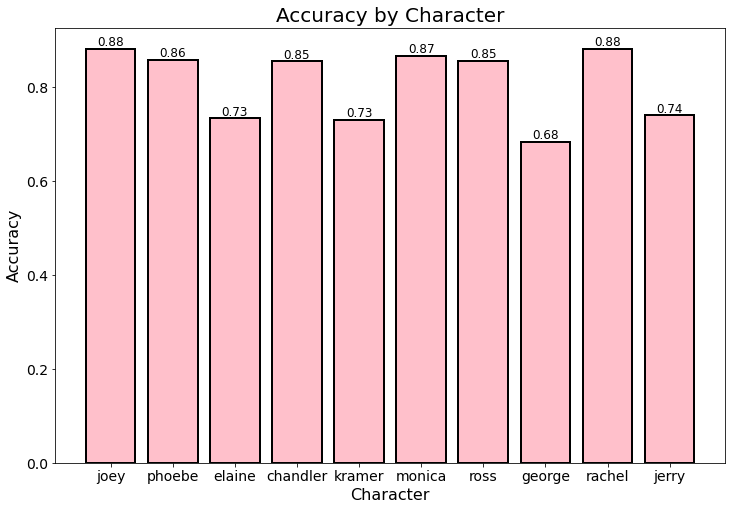

In [37]:
# Plot the results
plt.figure(figsize=(12, 8))
plt.bar(accuracy_by_character.keys(), accuracy_by_character.values(), color='pink', edgecolor='black', linewidth=2)

plt.xlabel('Character', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Accuracy by Character', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=14)

for character, accuracy in accuracy_by_character.items():
    plt.text(character, accuracy, f'{accuracy:.2f}', ha='center', va='bottom', fontsize=12)

plt.show()


## **Summary**

In [38]:
# Keep keys the same, and replace values according to your results and the specified type 

results = {'Test set accuracy' : ['0.8268'],
           'Train set accuracy': ['0.9003'] ,
           'Number of trainable parameters': ['5,036,697'],
           'Number of layers': ['6'],
           'Regularization methods': ['Dropout'],
           'Number of epochs': ['5'],
           'Choice of loss function': ['Binary Crossentropy'],
           'Choice of optimizer': ['adam'],
           'Embedding dimension': ['200']}

result = pd.DataFrame(results)
result

,Test set accuracy,Train set accuracy,Number of trainable parameters,Number of layers,Regularization methods,Number of epochs,Choice of loss function,Choice of optimizer,Embedding dimension
0,0.8268,0.9003,"5,036,697",6,Dropout,5,Binary Crossentropy,adam,200


In [ ]:
import os
from google.colab import files
result.to_csv(os.path.join(os.getcwd(), 'exercise3.csv'))
files.download('exercise3.csv')